In [ ]:
!pip install tsaug


In [ ]:
import os
import io
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib
#%matplotlib inline
from matplotlib import pyplot as plt
#plt.rcParams['figure.figsize'] = 12, 10

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image
from IPython.display import FileLink

import datetime as dt
from datetime import date, timedelta, datetime

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor

from scipy import stats
import statsmodels.api as sm
from itertools import product

# import xgboost as xgb
# from xgboost import plot_tree
from matplotlib.pylab import rcParams

# from fbprophet import Prophet
# from fbprophet.make_holidays import make_holidays_df
# from fbprophet.diagnostics import cross_validation, performance_metrics
# from fbprophet.plot import plot_cross_validation_metric
# import holidays

import tsaug
from tsaug import AddNoise, Convolve, Crop, Drift, Pool, Quantize, Resize, Reverse, TimeWarp
from tsaug.visualization import plot

In [ ]:
df = df[df['ID_Station'].isin([27, 28, 29])]
df['date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
df = df[['ID_Station','date','NH4']]
display(df)

<ipython-input-4-87c925385720>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')


,ID_Station,date,NH4
1713,27,1993-02-16,1.400
1714,27,1993-06-18,0.730
1715,27,1993-08-05,0.475
1716,27,1993-11-03,0.625
1717,27,1994-02-08,1.550
...,...,...,...
2674,29,2019-06-12,0.500
2675,29,2019-07-10,0.330
2676,29,2019-08-07,0.300
2677,29,2019-09-11,0.210


In [ ]:
df = pd.pivot_table(df, values='NH4', index=['date'], columns='ID_Station')
df = df[[27, 28, 29]]
df.columns = ['target', 'K1', "K2"]
df = df.dropna().reset_index(drop=False)
df

,date,target,K1,K2
0,1994-06-20,0.70,0.80,0.70
1,1994-07-06,0.53,0.39,0.65
2,1994-08-11,0.21,0.38,0.55
3,1994-09-13,0.60,0.60,0.90
4,1994-09-29,3.40,2.20,2.40
...,...,...,...,...
278,2019-06-12,0.30,0.37,0.50
279,2019-07-10,0.36,0.37,0.33
280,2019-08-07,0.43,0.35,0.30
281,2019-09-11,0.25,0.26,0.21


In [ ]:
target = df.pop('target')
df2 = df[['date', 'K1']]
df2 = df2.dropna().reset_index(drop=True)
def draw_plot(X_aug, Y_aug):
    plt.plot(X_aug, Y_aug, linewidth=5);
    plt.plot(X, Y, color='r', linewidth=1);

In [ ]:
def draw_plot_px(title_plot, X_aug, Y_aug, flag=True):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_aug, y=Y_aug,
                        mode='lines',
                        name='Processed data'))
    if flag:
        fig.add_trace(go.Scatter(x=X, y=Y,
                            mode='lines',
                            name='Origin data'))
    fig.update_layout(title=title_plot)
    fig.show()

In [ ]:
def draw_plot_px2(title_plot, X_aug, Y_aug, label1, X_aug2, Y_aug2, label2):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_aug, y=Y_aug,
                        mode='lines',
                        name=label1))
    fig.add_trace(go.Scatter(x=X_aug2, y=Y_aug2,
                        mode='lines',
                        name=label2))
    fig.add_trace(go.Scatter(x=X, y=Y,
                        mode='lines',
                        name='Origin data'))
    fig.update_layout(title=title_plot)
    fig.show()

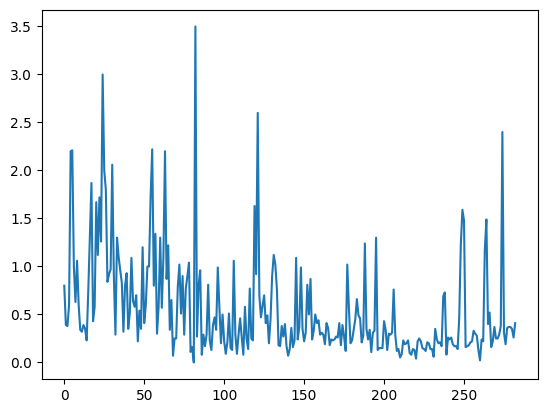

In [ ]:
X = np.arange(len(df))
Y = df['K1'].tolist()
plt.plot(X, Y);

In [ ]:
Y = np.array(Y)
Y[:3]

array([0.8 , 0.39, 0.38])

In [ ]:
Y_aug, X_aug = tsaug.AddNoise(scale=0.1).augment(Y, X)
Y_aug2, X_aug2 = tsaug.AddNoise(scale=0.05).augment(Y, X)
draw_plot_px2('Adding Noise', X_aug, Y_aug, 'scale=0.1', X_aug2, Y_aug2,'scale=0.05')

In [ ]:
Y_aug, X_aug = tsaug.Convolve(window="flat", size=10).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Convolve(window="flat", size=30).augment(Y, X)
draw_plot_px2('Adding Convolution', X_aug, Y_aug, 'flat with size=10', X_aug2, Y_aug2, 'flat with size=30')

In [ ]:

Y_aug, X_aug = tsaug.Crop(size=100).augment(Y_aug, X_aug)
Y_aug, X_aug = tsaug.Convolve(window="flat", size=10).augment(Y_aug, X_aug)

Y_aug2, X_aug2 = tsaug.Crop(size=10).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Convolve(window="flat", size=30).augment(Y_aug2, X_aug2)
draw_plot_px2('Adding Convolution', X_aug, Y_aug, 'Crop, size=100 & Flat, size=10',
              X_aug2, Y_aug2, 'Crop, size=10 & Flat, size=30')

In [ ]:
Y_aug, X_aug = tsaug.Drift(max_drift=0.3, n_drift_points=5).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Drift(max_drift=0.5, n_drift_points=5).augment(Y, X)
draw_plot_px2('Adding Drift', X_aug, Y_aug, 'max_drift=0.3, n_drift_points=5',
              X_aug2, Y_aug2, 'max_drift=0.5, n_drift_points=5')

In [ ]:
Y_aug, X_aug = tsaug.Quantize(n_levels=10).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Quantize(n_levels=20).augment(Y, X)
draw_plot_px2('Adding Quantize', X_aug, Y_aug, 'n_levels=10', X_aug2, Y_aug2, 'n_levels=20')

In [ ]:
Y_aug, X_aug = tsaug.Resize(size=10).augment(Y, X)
Y_aug2, X_aug2 = tsaug.Resize(size=50).augment(Y, X)
draw_plot_px2('Adding Resize', X_aug, Y_aug, 'size=10', X_aug2, Y_aug2, 'size=50')

In [ ]:
Y_aug, X_aug = tsaug.Reverse().augment(Y, X)
draw_plot_px('Adding Reverse', X_aug, Y_aug)

In [ ]:
Y_aug, X_aug = tsaug.TimeWarp(n_speed_change=2, max_speed_ratio=3).augment(Y, X)
Y_aug2, X_aug2 = tsaug.TimeWarp(n_speed_change=20, max_speed_ratio=3).augment(Y, X)
draw_plot_px2('Adding TimeWarp', X_aug, Y_aug, 'n_speed_change=2, max_speed_ratio=3',
              X_aug2, Y_aug2, 'n_speed_change=20, max_speed_ratio=3')
Y_aug, X_aug = tsaug.TimeWarp(n_speed_change=20, max_speed_ratio=3).augment(Y, X)
Y_aug2, X_aug2 = tsaug.TimeWarp(n_speed_change=20, max_speed_ratio=5).augment(Y, X)
draw_plot_px2('Adding TimeWarp', X_aug, Y_aug, 'n_speed_change=20, max_speed_ratio=3',
              X_aug2, Y_aug2, 'n_speed_change=20, max_speed_ratio=5')